# Determining patient fate

In [23]:
import scanpy as sc
import pandas as pd
import cellrank as cr
import ehrapy as ep
import numpy as np

In [24]:
df_annotations = pd.read_csv("public-annotations.csv")

filenames = pd.read_csv("filenames.csv", index_col=None)

df_annotations = df_annotations[
    df_annotations.filename.isin(list(filenames["filename"]))
].reset_index(drop=True)
df_annotations["geographic_mean"] = df_annotations["S-Global"]

In [25]:
df_annotations["geographic_mean"].replace(
    [
        0,
        1,
        2,
    ],
    "Normal",
    inplace=True,
)
df_annotations["geographic_mean"].replace([3, 4, 5], "Mild", inplace=True)
df_annotations["geographic_mean"].replace([6, 7, 8, 9, 10, 11], "Medium", inplace=True)
df_annotations["geographic_mean"].replace(
    [12, 13, 14, 15, 16, 17, 18], "Severe", inplace=True
)

In [26]:
adata = sc.read_csv(f"embeddings.csv")
adata.obs["geographic_mean"] = df_annotations["geographic_mean"].values
adata.obs["image_name"] = filenames["filename"].values

In [27]:
palette = {
    "Normal": "yellowgreen",
    "Mild": "darkorange",
    "Medium": "mediumturquoise",
    "Severe": "red",
}

/home/zeth/miniconda3/envs/ehrapy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


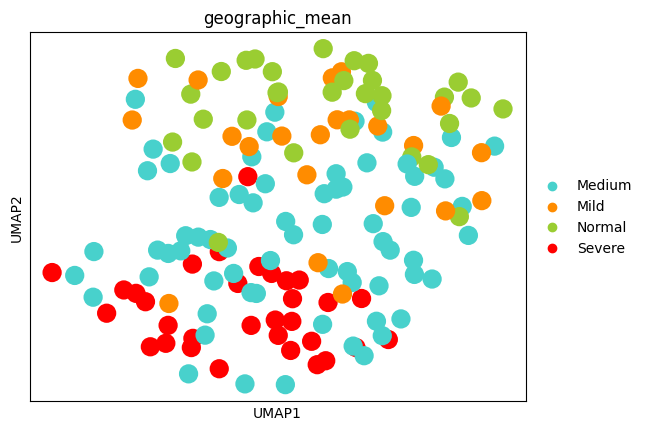

In [28]:
ep.pp.pca(adata)
ep.pp.neighbors(adata)
ep.tl.umap(adata, n_components=3)
ep.pl.umap(adata, color=["geographic_mean"], palette=palette)

100%|██████████| 156/156 [00:00<00:00, 687.07cell/s]


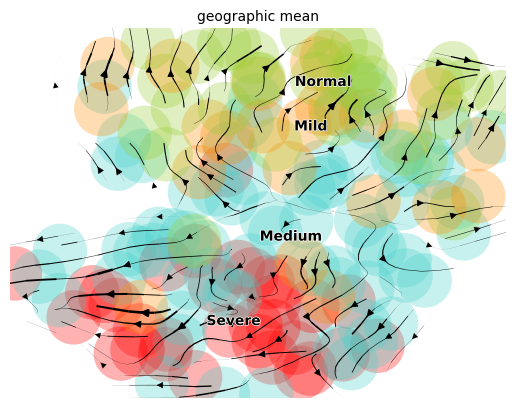

In [29]:
adata.uns["iroot"] = np.flatnonzero(adata.obs["geographic_mean"] == "Normal")[0]
ep.tl.dpt(adata)
pk = cr.kernels.PseudotimeKernel(adata, time_key="dpt_pseudotime")
pk.compute_transition_matrix(threshold_scheme="soft")
pk.plot_projection(
    basis="umap", stream=True, color="geographic_mean", density=1, smooth=True
)

100%|██████████| 156/156 [00:00<00:00, 631.48cell/s]


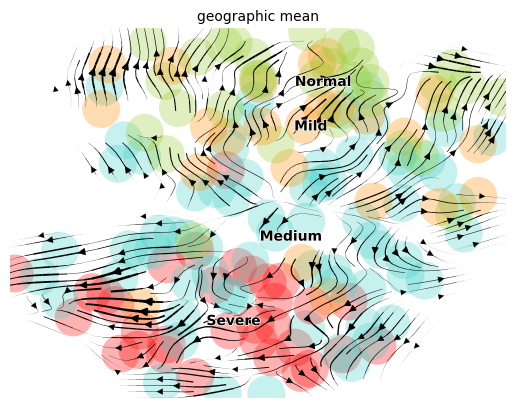

In [30]:
adata.uns["iroot"] = np.flatnonzero(adata.obs["geographic_mean"] == "Normal")[0]
ep.tl.dpt(adata)
pk = cr.kernels.PseudotimeKernel(adata, time_key="dpt_pseudotime")
pk.compute_transition_matrix(threshold_scheme="soft")
pk.plot_projection(
    basis="umap", stream=True, color="geographic_mean", smooth=True, size=3000
)

The images that are not quite where they should be:

**Normal**

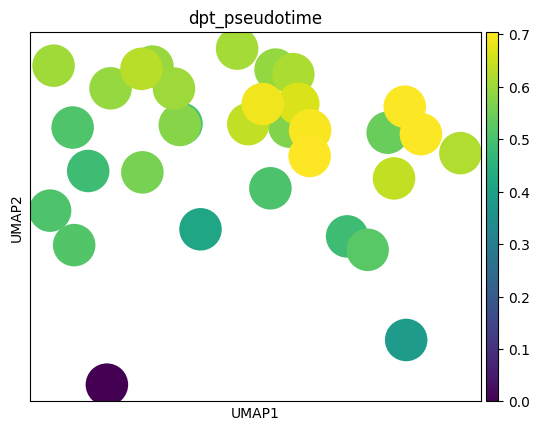

In [31]:
ep.pl.umap(adata[adata.obs.geographic_mean == "Normal"], color="dpt_pseudotime")

In [32]:
normal_only = adata.obs[adata.obs.geographic_mean == "Normal"].sort_values(
    by="dpt_pseudotime"
)
normal_only

,geographic_mean,image_name,dpt_pseudotime
84,Normal,cavitating-pneumonia-4-day28-PA.png,0.000000
85,Normal,covid-19-pneumonia-30-PA.jpg,0.383975
114,Normal,covid-19-pneumonia-24-day12.jpg,0.416482
117,Normal,covid-19-pneumonia-evolution-over-a-week-1-day...,0.485224
107,Normal,1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf...,0.486087
140,Normal,figure1-5e7c1b8d98c29ab001275405-98-later.jpeg,0.498637
142,Normal,radiol.2020201160.fig6b.jpeg,0.504568
135,Normal,covid-19-pneumonia-40.jpg,0.507975
113,Normal,covid-19-pneumonia-24-day7.jpg,0.509829
106,Normal,legionella-pneumonia-2.jpg,0.512736


In [34]:
normal_only.loc["84"]

geographic_mean                                 Normal
image_name         cavitating-pneumonia-4-day28-PA.png
dpt_pseudotime                                     0.0
Name: 84, dtype: object

## Mild

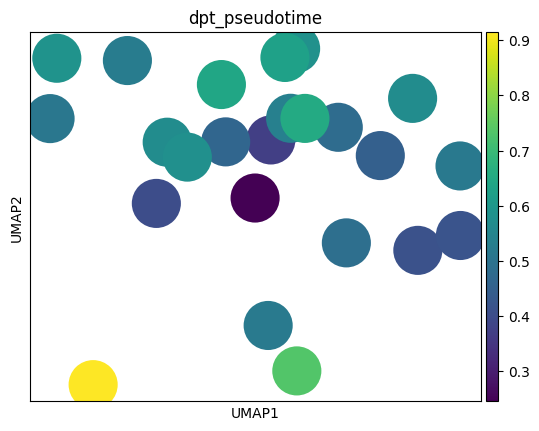

In [35]:
ep.pl.umap(adata[adata.obs.geographic_mean == "Mild"], color="dpt_pseudotime")

In [39]:
normal_only = adata.obs[adata.obs.geographic_mean == "Mild"].sort_values(
    by="dpt_pseudotime", ascending=False
)
normal_only

,geographic_mean,image_name,dpt_pseudotime
47,Mild,2C26F453-AF3B-4517-BB9E-802CF2179543.jpeg,0.915132
57,Mild,kjr-21-e24-g002-l-a.jpg,0.732351
132,Mild,covid-19-pneumonia-49-day8.jpg,0.652408
127,Mild,covid-19-pneumonia-53.jpg,0.642684
128,Mild,post-intubuation-pneumomediastium-and-pneumoth...,0.627159
126,Mild,4e43e48d52c9e2d4c6c1fb9bc1544f_jumbo.jpeg,0.589292
116,Mild,covid-19-pneumonia-evolution-over-a-week-1-day...,0.582051
102,Mild,pneumocystis-jiroveci-pneumonia-2.png,0.577853
125,Mild,covid-19-caso-70-2-APS.jpg,0.568869
105,Mild,legionella-pneumonia-1.png,0.567193


In [40]:
normal_only.loc["47"]

geographic_mean                                         Mild
image_name         2C26F453-AF3B-4517-BB9E-802CF2179543.jpeg
dpt_pseudotime                                      0.915132
Name: 47, dtype: object

## Medium

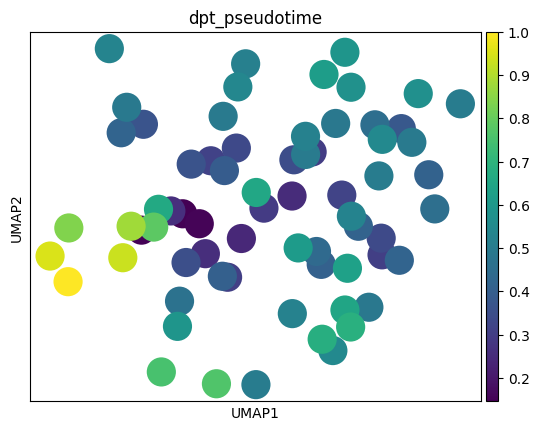

In [41]:
ep.pl.umap(adata[adata.obs.geographic_mean == "Medium"], color="dpt_pseudotime")

In [42]:
normal_only = adata.obs[adata.obs.geographic_mean == "Medium"].sort_values(
    by="dpt_pseudotime", ascending=False
)
normal_only

,geographic_mean,image_name,dpt_pseudotime
46,Medium,F63AB6CE-1968-4154-A70F-913AF154F53D.jpeg,1.000000
54,Medium,7E335538-2F86-424E-A0AB-6397783A38D0.jpeg,0.951125
35,Medium,F2DE909F-E19C-4900-92F5-8F435B031AC6.jpeg,0.932365
20,Medium,1-s2.0-S0929664620300449-gr2_lrg-d.jpg,0.878477
31,Medium,2C10A413-AABE-4807-8CCE-6A2025594067.jpeg,0.839743
...,...,...,...
66,Medium,C6EA0BE5-B01E-4113-B194-18D956675E25.jpeg,0.248981
63,Medium,FE9F9A5D-2830-46F9-851B-1FF4534959BE.jpeg,0.239980
60,Medium,1-s2.0-S1684118220300682-main.pdf-002-a2.png,0.154153
59,Medium,1-s2.0-S1684118220300682-main.pdf-002-a1.png,0.149093


In [43]:
normal_only.loc[["46", "54", "35"]]

,geographic_mean,image_name,dpt_pseudotime
46,Medium,F63AB6CE-1968-4154-A70F-913AF154F53D.jpeg,1.000000
54,Medium,7E335538-2F86-424E-A0AB-6397783A38D0.jpeg,0.951125
35,Medium,F2DE909F-E19C-4900-92F5-8F435B031AC6.jpeg,0.932365


## Severe

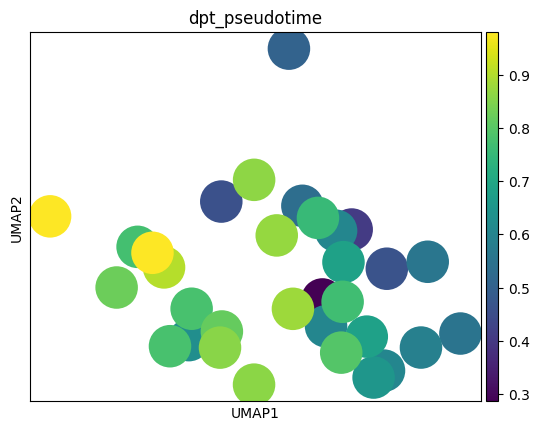

In [45]:
ep.pl.umap(adata[adata.obs.geographic_mean == "Severe"], color="dpt_pseudotime")